In [9]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from compartment import SIRModel, SEIRModel
from models import BinomialApprox, ExponentialRandomWalk, observe, plot_samples

## Model: SEIR model for new cases with random parameters/observations, deterministic dynamics

# Load and Prep Data

In [4]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

In [16]:
place = 'NY'

start = pd.Timestamp('2020-03-04')
confirmed = data[place].confirmed[start:]
start = confirmed.index.min()

T = len(confirmed)
N = pop[place]

kernel = NUTS(SEIR_stochastic)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)

E_dur = 4.0
I_dur = 1.5
R0 = 3.5

init = {
    'E0': 1000.,
    'I0': 1000.,
    'sigma': 1 / E_dur,
    'gamma': 1 / I_dur,
    'beta0': R0 / I_dur,
    'beta': np.repeat(R0 / I_dur, T-1),
    'det_rate' : 0.3
}


args = {
    'N': N,
    'T': T,
    'drift_scale': 1e-1,
    'det_conc': 100,
}

mcmc.run(jax.random.PRNGKey(1), 
         obs = confirmed.values,
         init_params = init,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Posterior predictive samples for visualization
post_pred = Predictive(SEIR_stochastic, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

sample: 100%|██████████| 2000/2000 [01:29<00:00, 22.37it/s, 63 steps of size 2.61e-02. acc. prob=0.92]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    246.03     73.09    235.11    134.80    356.46    381.12      1.00
        I0     23.22      6.25     21.99     14.56     33.31    634.74      1.00
   beta[0]      1.72      0.43      1.69      1.07      2.40    322.97      1.00
   beta[1]      1.73      0.42      1.68      1.09      2.37    464.00      1.00
   beta[2]      1.74      0.40      1.70      1.14      2.33    619.73      1.00
   beta[3]      1.75      0.39      1.71      1.12      2.30    761.33      1.00
   beta[4]      1.80      0.39      1.76      1.20      2.38    744.57      1.00
   beta[5]      1.90      0.41      1.85      1.28      2.54    711.39      1.00
   beta[6]      2.05      0.45      1.99      1.31      2.71    720.73      1.00
   beta[7]      2.26      0.50      2.19      1.52      3.10    671.10      1.00
   beta[8]      2.50      0.55      2.43      1.71      3.42    733.26      1.00
   beta[9]      2.74      0

# Inspect Results

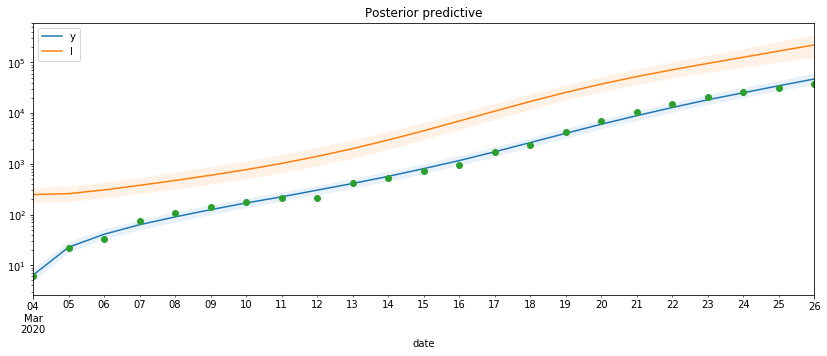

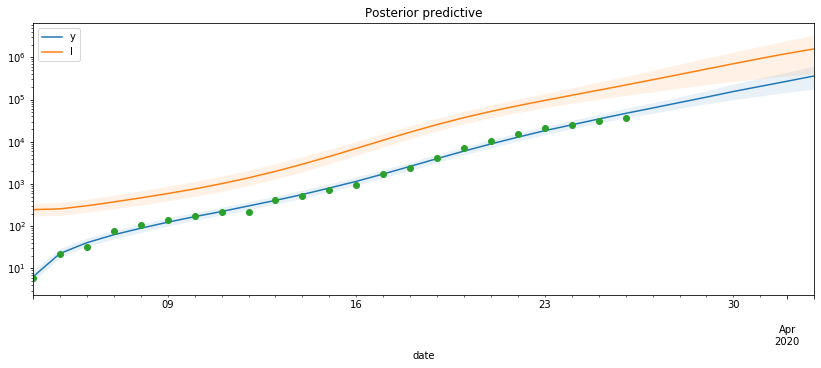

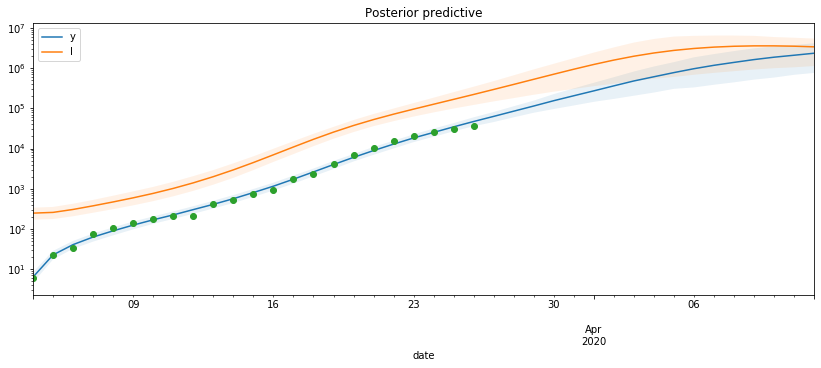

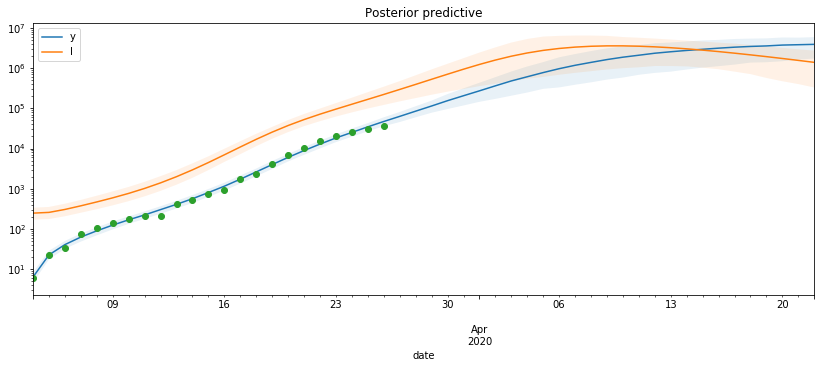

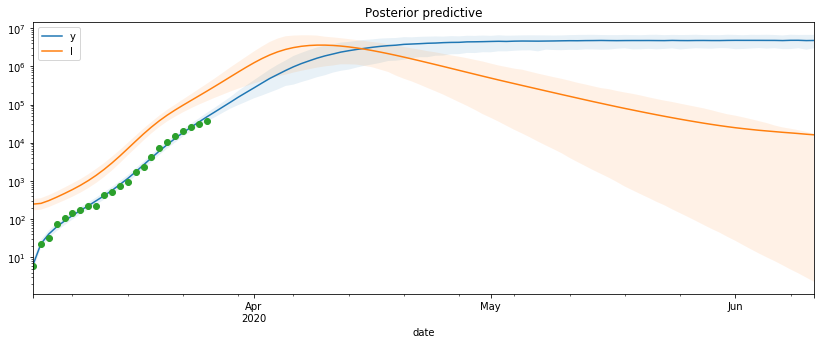

In [12]:
scale = 'log'

for T in [len(confirmed), 30, 40, 50, 100]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['y', 'I'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    plt.savefig(filename)
    plt.show()

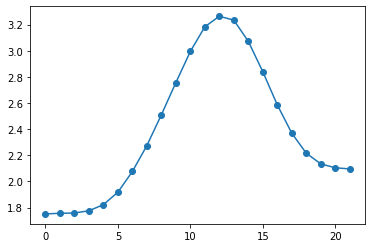

In [13]:
beta = mcmc_samples['beta']
plt.plot(beta.mean(axis=0), '-o')

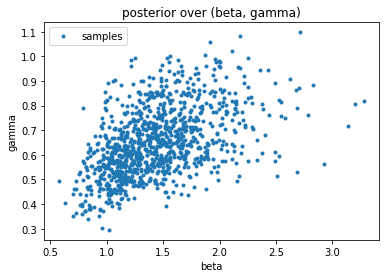

R0: 2.2503822


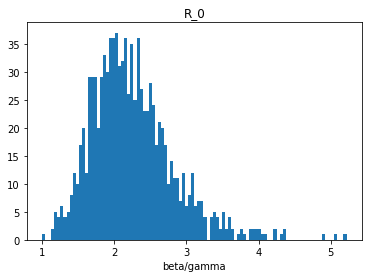

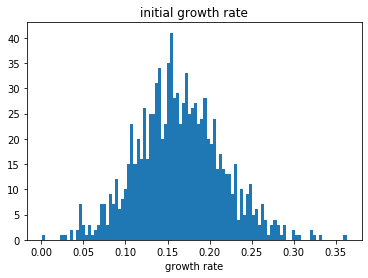

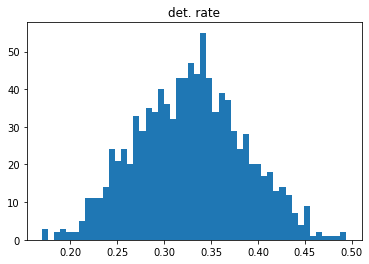

In [131]:
save = False

beta = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
#offset = (beta-gamma).mean()
#plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('initial growth rate')
plt.xlabel('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

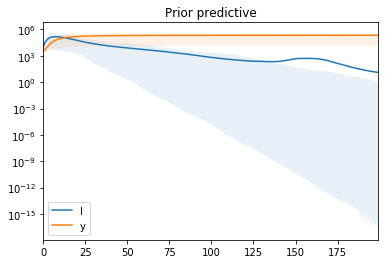

In [7]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'E', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
#     for i in range(5):
#         test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()

(array([ 12., 103., 292., 301., 184.,  77.,  21.,   3.,   4.,   3.]),
 array([0.09735882, 0.16229184, 0.22722486, 0.29215786, 0.3570909 ,
        0.4220239 , 0.4869569 , 0.5518899 , 0.61682296, 0.68175596,
        0.74668896], dtype=float32),
 <a list of 10 Patch objects>)

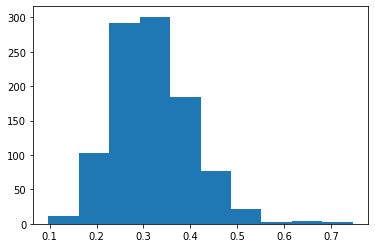

In [140]:
beta = mcmc_samples['beta0'] 
gamma = mcmc_samples['gamma']
sigma = mcmc_samples['sigma']
l = SEIRModel.growth_rate((beta, sigma, gamma))
plt.hist(l)

In [141]:
confirmed

date
2020-03-04       2.0
2020-03-05       2.0
2020-03-06       8.0
2020-03-07      13.0
2020-03-08      13.0
2020-03-09      41.0
2020-03-10      92.0
2020-03-11      92.0
2020-03-12      95.0
2020-03-13     123.0
2020-03-14     138.0
2020-03-15     138.0
2020-03-16     164.0
2020-03-17     218.0
2020-03-18     256.0
2020-03-19     328.0
2020-03-20     413.0
2020-03-21     525.0
2020-03-22     646.0
2020-03-23     777.0
2020-03-24    1159.0
2020-03-25    1838.0
2020-03-26    2417.0
Name: confirmed, dtype: float64